# METRO MANILA AMBULANCE RESPONSE NETWORK SIMULATION

In [25]:
import networkx as nx 
import numpy as np 
import random as rand
import matplotlib.pyplot as plt 
import scipy.stats as sts 
import heapq 
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra 


## Setting up Scheduler 

We use the scheduler to handle multiple tasks of the network simulation. 

In [26]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

The city that is being modeled is currently the National Capital Region (NCR) of the Philippines that is consist of multiple cities. The follow table shows the list of cities to be considered in this network analysis along with its generated city codes. 

### City Codes 

|    | City        | Code |
|----|-------------|------|
| 1  | Cavite      | cav  |
| 2  | Las Pinas   | las  |
| 3  | Muntinlupa  | mun  |
| 4  | Paranaque   | pnq  |
| 5  | Pasay       | psy  |
| 6  | Taguig      | tag  |
| 7  | Makati      | mak  |
| 8  | Mandaluyong | mnd  |
| 9  | Manila      | mnl  |
| 10 | San Juan    | snj  |
| 11 | Pasig       | psg  |
| 12 | Pateros     | pts  |
| 13 | Rizal       | rzl  |
| 14 | Marikina    | mka  |
| 15 | Quezon      | qzn  |
| 16 | Caloocan    | cal  |

The edge weights are based on relative distances on the map. This was just measured randomly based on the edge lengths. We will be using minutes as our proper edge weights for the simulation and so we multiplied it by 20 to have a bigger scale of values and have a bit freedom to move around. The weights of the edges would represent the response time of the ambulance going to and from the source and target node. 

In [27]:
def create_NCR():
    """
    This function creates the NCR set-up to a network structure. 
    It returns the network with the respectively connected nodes 
    """

    NCR = nx.Graph() 

    NCR.add_edge("cav", "mun", weight = 4)
    NCR.add_edge("cav", "las", weight = 5)

    NCR.add_edge("mun", "las", weight = 2)
    NCR.add_edge("mun", "pnq", weight = 4)

    NCR.add_edge("las", "pnq", weight = 1.5)

    NCR.add_edge("pnq", "psy", weight = 3) 
    NCR.add_edge("pnq", "tag", weight = 2.5) 

    NCR.add_edge("psy", "tag", weight = 3)
    NCR.add_edge("psy", "mak", weight = 1)
    NCR.add_edge("psy", "mnl", weight = 3.5)

    NCR.add_edge("tag", "pat", weight = 1.8)
    NCR.add_edge("tag", "psg", weight = 2)
    NCR.add_edge("tag", "rzl", weight = 6)

    NCR.add_edge("pat", "mak", weight = 1.5)
    NCR.add_edge("pat", "psg", weight = 1) 

    NCR.add_edge("mak", "mnl", weight = 1.3)
    NCR.add_edge("mak", "mnd", weight = 1.5)
    NCR.add_edge("mak", "psg", weight = 1.5)

    NCR.add_edge("mnl", "mnd", weight = 2.8)
    NCR.add_edge("mnl", "snj", weight = 3.3)
    NCR.add_edge("mnl", "qzn", weight = 4.2)
    NCR.add_edge("mnl", "cal", weight = 3.1)

    NCR.add_edge("cal", "qzn", weight = 3.7)

    NCR.add_edge("qzn", "snj", weight = 3.2)
    NCR.add_edge("qzn", "psg", weight = 4.3) 
    NCR.add_edge("qzn", "mka", weight = 3.3)

    NCR.add_edge("snj", "mnd", weight = 1)

    NCR.add_edge("mnd", "psg", weight = 1.5)

    NCR.add_edge("psg", "mka", weight = 4)
    NCR.add_edge("psg", "rzl", weight = 5.5)

    NCR.add_edge("mka", "rzl", weight = 3)
    
    # Scaling to 20 for better interpretation in graphing and timing 
    # We are going to deal with minutes here 
    for u,v,d in NCR.edges(data = True):
        d['weight'] *= 5

    return NCR 



In [101]:
NCR = create_NCR()
pos = nx.spring_layout(NCR)

NCR Layout overview


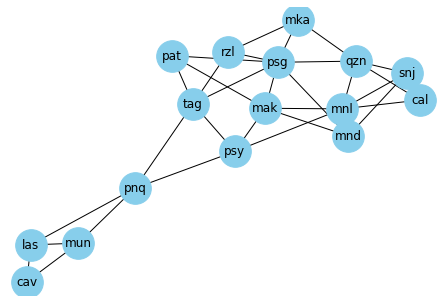

In [145]:
print("NCR Layout overview")
nx.draw(NCR, pos = pos, with_labels = True, node_color = 'skyblue', node_size = 1000)


In [148]:
print("Network stats:")
print("----")
print('Edges:', len(NCR.edges()))
print("Nodes:", len(NCR.nodes()))

Network stats:
----
Edges: 31
Nodes: 16


In [242]:
class NCR_network:
    
    def __init__(self, random_ambulance, station_count, num_ambulances, ambulance_stations,
                 arrival_rate, service_rate, end_sim):
        """
        
        Inputs:
        - random_ambulance = randomly allocate ambulances 
        - station_count = number of nodes with ambulances 
        - num_ambulance = number of ambulance per node 
        - ambulance_stations = list containting nodes that have ambulance stations 
        
        - arrival_rate = rate of calls 
        - service_rate = how fast ambulances serve at the area 
        """
        
        self.g = create_NCR() 
        self.g.pos = nx.spring_layout(self.g)
        self.time = 0 
        self.end_sim = end_sim 
        
        self.ambulance_stations = [] 
        self.emergency_waitlist = [] 
        self.total_emergencies = [] # queue length per time step 
        
        # Tracking current metrics of entire network 
        self.available_ambulances = 0
        self.emergencies = 0
        self.ambulances_in_response = 0
        self.nodes_getting_response = 0 
        
        # Node-specific metrics 
        self.times_in = []
        self.times_out = [] 
        
        # Determine distributions 
        # This is for modeling call arrivals 
        self.arrival_distribution = sts.expon(scale = arrival_rate)
        
        # This is for modeling the service time in the area of emergency 
        self.service_distribution = sts.norm(loc = service_rate, scale = 2)
        
        # Initialize Attributes 
        for node in self.g.nodes():
            self.g.nodes[node]['emergencies'] = 0 
            self.g.nodes[node]['station'] = False
            
            
        # randomly allocate ambulances
        if random_ambulance == True:
            ambulance_stations = np.random.choice(self.g.nodes(), station_count, replace = False)
            
            self.ambulance_stations = ambulance_stations 
            
        else:
            self.ambulance_stations = ambulance_stations 
            
        for node in self.ambulance_stations: 
            self.g.nodes[node]['ambulances'] = num_ambulances
            self.g.nodes[node]['station'] = True 
            self.available_ambulances += num_ambulances
            
        
    def observe(self):
        color_map = []
        for node in self.g.nodes(): 
            if self.g.nodes[node]['station'] == True:
                color_map.append("orange")
                
            else:
                color_map.append("skyblue")
                
        nx.draw(self.g, pos = self.g.pos, with_labels = True, node_color = color_map, node_size = 1000)
        plt.show()
        
    def get_metrics(self):
        print("Available ambulances:", self.available_ambulances)
        print("Total emergencies:", self.total_emergencies)
        print("Ambulances in Response:", self.ambulances_in_response)
        print("Nodes Getting Response:", self.nodes_getting_response)
        
        
    def get_nearest_ambulance(self, node):
        
        results = []
        for station in self.ambulance_stations:
            if self.g.nodes[station]['ambulances'] > 0: 
                results.append(single_source_dijkstra(self.g, node, station))
    
        target = min(results, key = lambda t: t[0])
        
        distance = target[0]
        chosen_station = target[1][-1]
        
        if results == []:
            return raiseValueError("There are no ambulances available") 
        else:
            return (distance, chosen_station)
        
        
    def generate_call(self, schedule):
        """
        Randomly generate a call at a random node
        """
        node = np.random.choice(self.g.nodes())
        
        # Update variables
        self.emergencies += 1
        self.total_emergencies.append(self.emergencies)
        self.times_in.append(schedule.now) 
        self.emergency_waitlist.append(node)
        
        # If sim is still a go, we schedule next emergency call 
        if self.end_sim == False:
            node = np.random.choice(self.g.nodes())
            schedule.add_event_after(self.arrival_distribution.rvs(), self.generate_call)
        
        # Report to call center for logistics 
        self.call_center(schedule)        


    def call_center(self, schedule):
        """
        Manages the logistics behind calls and allocation of emergency vehicles
        """
        
        # Check for the current waitlist of emergencies 
        if self.emergency_waitlist:
            
            # Check if there are available ambulances 
            if self.available_ambulances > 0:
            
                curr = self.emergency_waitlist[0]
                
                # Search best station to allocate 
                distance, station = self.get_nearest_ambulance(curr)
                self.g.nodes[station]['ambulances'] -= 1 
                schedule.add_event_after(0, self.start_responding_emergency,node = curr, distance = distance, 
                                                                            station = station)
                
                del self.emergency_waitlist[0]
             

    def start_responding_emergency(self, schedule, node, distance, station): 
        """
        Schedule a response to the site that requires assistance 
        """
        
        self.total_emergencies -= 1 
        self.available_ambulances -= 1 
        self.nodes_getting_response += 1 
        self.ambulances_in_response += 1 

        
        # Acquire amount of time spent in the location 
        serve = self.service_distribution.rvs()

        response_time = distance + serve # going to location 
        service_time = distance * 2 + serve # roundtrip 
        
        self.times_out.append(schedule.now + response_time)
        
        schedule.add_event_after(service_time, self.finish_responding_emergency, 
                                 node = node, station = station)
        
    def finish_responding_emergency(self, schedule, node, station):
        """
        For when an ambulance has returned, they will have to report back to the 
        call center 
        """
        
        self.available_ambulances += 1
        self.ambulances_in_response -= 1 
        self.nodes_getting_response -= 1 
        
        self.g.nodes[station]['ambulances'] += 1 
        
        # Report to call center for logistics 
        self.call_center(schedule)
        
    def run(self, schedule):
        schedule.add_event_after(self.arrival_distribution.rvs(), 
                                self.generate_call)
        

### Simulation Function

In [277]:
def run_simulation(run_until, random_ambulance, station_count, num_ambulances, ambulance_stations,
                  arrival_rate, service_rate, end_sim):
    
    # Set-up scheduler 
    schedule = Schedule() 
    
    # Metrics 
    
    
    # Set-up network class and simulation 
    city_network = NCR_network(random_ambulance = random_ambulance, ambulance_stations = ambulance_stations,
                               station_count = station_count, num_ambulances = num_ambulances,
                               arrival_rate = arrival_rate, service_rate = service_rate, end_sim = end_sim)
    city_network.run(schedule)
    
    # Show graph set-up 
#     city_network.observe()
    
    while schedule.next_event_time() < run_until:
        
        schedule.run_next_event() 
        
        per_busy_ambulance.append(city_network.ambulances_in_response)
        
    city_network.end_sim = True
    
    while schedule.priority_queue:
        
        schedule.run_next_event()
    
    
    return city_network
    

### Parameters Discussion
The current parameters that were estimated are the following:
1. Arrival time: data was not available online. Thus, I estimated based on the model’s scale (city-based and assuming that there is only 1 station per city). An emergency call is expected every 20 minutes and was modeled with an exponential distribution to be used for the scheduling function. This variable is crucial since it sets the level of need for responses in the entire region. The whole simulation will be building upon this variable. 
2. The number of ambulances are set to 2 per station as it is considered as the average per hospital. This variable affects the availability of a station and can highly affect nodes with high degrees as they are expected to encounter more calls. 
3. Service time: the service time of the responders are modeled with a normal distribution with a mean of 7 and a standard deviation of 2 since these are trained individuals and consistency in speed should be exhibited. The variability accounts for the different types of assistance that is required in the location of the situation. 


#### Selected Allocation of ambulances 

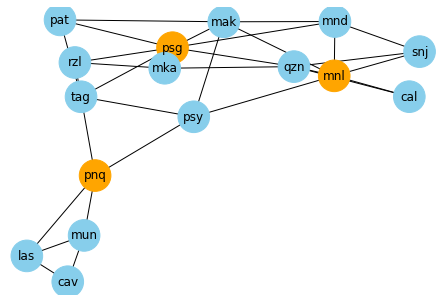

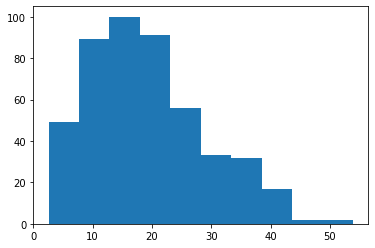

In [287]:
ambulance_stations = ['psg', 'mnl', 'pnq']

sim = run_simulation(10000, random_ambulance = False, station_count = 3, 
                    num_ambulances = 2, arrival_rate = 20, service_rate = 7,
                     end_sim = False, ambulance_stations = ambulance_stations)
sim.observe()

ins = np.array(sim.times_in)

outs = np.array(sim.times_out) 


plt.hist((outs - ins))
plt.show()

#### Random Allocation of ambulances 

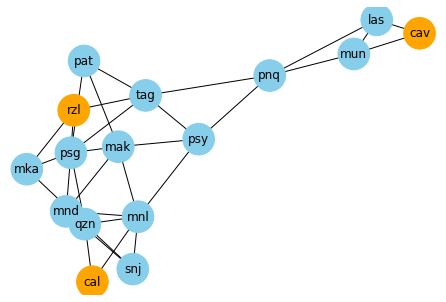

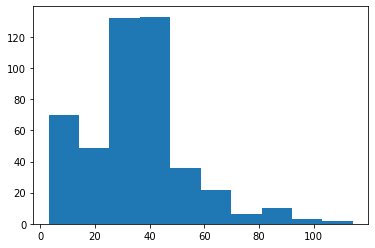

In [298]:
ambulance_stations = ['psg', 'mnl', 'pnq']

sim = run_simulation(10000, random_ambulance = False, station_count = 3, 
                    num_ambulances = 2, arrival_rate = 20, service_rate = 7,
                     end_sim = False, ambulance_stations = bad_ambulance_stations)
sim.observe()

ins = np.array(sim.times_in)

outs = np.array(sim.times_out) 


plt.hist((outs - ins))
plt.show()

## Strategic Mapping 

Here, we are investigating if choosing the location with the higest degree and ease of connection will have an effect in the average response time of ambulances. 

Constant: 
1. Number of stations and ambulances per station 
2. Arrival and service rates 
3. Node Structure 

The strategically chosen nodes are of high degrees and act as bridges to clusters (Paranaque). The poorly chosen nodes are the ones that have long edges, low degrees, and are located at the very corners of the map.


In [274]:
# Strategically chosen nodes 
good_ambulance_stations = ['psg', 'mnl', 'pnq']

# Poorly chosen nodes 
bad_ambulance_stations = ['rzl', 'cav', 'cal']


In [294]:
def strat_map_sim(n_trials, stations):
    
    average_waiting_times = [] 
    
    for i in range(n_trials):
        sim = run_simulation(1000, random_ambulance = False, station_count = 3, 
                    num_ambulances = 2, arrival_rate = 20, service_rate = 7,
                     end_sim = False, ambulance_stations = stations)

        ins = np.array(sim.times_in)

        outs = np.array(sim.times_out) 


        wait_time = np.mean(outs - ins)
        average_waiting_times.append(wait_time)

    return average_waiting_times 

good_mapping = strat_map_sim(1000, good_ambulance_stations)
bad_mapping = strat_map_sim(1000, bad_ambulance_stations)

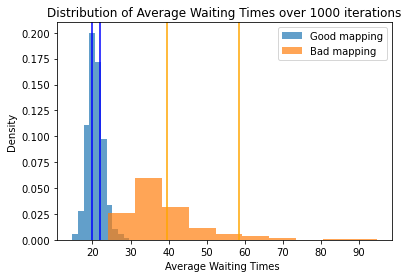

In [351]:
# def conf_int(data):
#     m = np.mean(data)
#     t = sts.sem(data)
#     return [np.round(m - 1.96*t,3), np.round(m + 1.96*t,3)]

def conf_int(data):
    
    return np.quantile(data, [0.025, 0.975])

good_mapping_conf_int = conf_int(good_mapping)
bad_mapping_conf_int = conf_int(bad_mapping)

plt.hist(good_mapping, alpha = 0.7, label = 'Good mapping', density = True)
plt.hist(bad_mapping, alpha = 0.7, label = 'Bad mapping', density = True)

plt.axvline(good_mapping[0], c = 'blue')
plt.axvline(good_mapping[1], c = 'blue')
plt.axvline(bad_mapping[0], c = 'orange')
plt.axvline(bad_mapping[1], c = 'orange')


plt.xlabel("Average Waiting Times ")
plt.ylabel("Density")
plt.title("Distribution of Average Waiting Times over 1000 iterations")
plt.legend()
plt.show() 

## Strategic Capacity Planning 

Here, we look into the difference variations of the number of ambulance stations and ambulances allocated to the city and see how it affects the waiting times. 

For the changing number of stations, we are randomly allocating the ambulance k times for every simulations.

For the changing number of ambulance counts. We will only be focusing on one set of ambulance stations. Here, we will use the bad mapping example. 

In [348]:
# Changing number of stations 
# Default = 3
varying_stations = [2, 3, 4, 5, 6]


# Changing number of ambulance counts 
# Default = 2 
varying_ambulance_counts = [2, 3, 4, 5, 6]



In [349]:
def conf_int(data):
    m = np.mean(data)
    t = sts.sem(data)
    return [np.round(m - 1.96*t,3), np.round(m + 1.96*t,3)]    

def conf_dist(data):
    m = np.mean(data)
    t = sts.sem(data)
    return 1.96*t
    
def hosp_count_modeling(n_trials, variables):

    # Acquire data
    hosp_count = variables # Number of Queue lines 
    tot_average_waiting_time = []
    tot_waiting_time_std = []
    tot_confidence_bars = []
    tot_confidence_intervals = []
    
    for var in variables:
    # We run simulations for every number of servers and queue lines 
        
        waiting_time = []

        for i in range(n_trials):
            sim = run_simulation(5000, random_ambulance = True, station_count = var, 
                        num_ambulances = 2, arrival_rate = 20, service_rate = 7,
                         end_sim = False, ambulance_stations = None)

            ins = np.array(sim.times_in)

            outs = np.array(sim.times_out) 


            wait_time = np.mean(outs - ins) 
            waiting_time.append(wait_time)
                
        # Compute statistics 
        m = np.mean(waiting_time)
        std = np.std(waiting_time)
        conf = conf_int(waiting_time)
        conf_bar = conf_dist(waiting_time)
        
#         queue_count.append(queue)
        tot_average_waiting_time.append(np.round(m,3))
        tot_waiting_time_std.append(std)
        tot_confidence_bars.append(conf_bar)
        tot_confidence_intervals.append(conf)

    # Plot error bar, we use confidence interval to show the bar range 
    plt.errorbar(hosp_count, tot_average_waiting_time, tot_confidence_bars,
                color = 'black', marker = 'o', capsize = 5, linestyle = '--', linewidth = 1)
    plt.title("Error Bar Plot for the Average Waiting Time Given the Number of Hospitals")
    plt.xlabel("Number of Hospitals")
    plt.ylabel("Average waiting time (mins)")
    plt.show()
    
    print("Expected Values:", tot_average_waiting_time)
    print("Confidence Intervals:", tot_confidence_intervals)

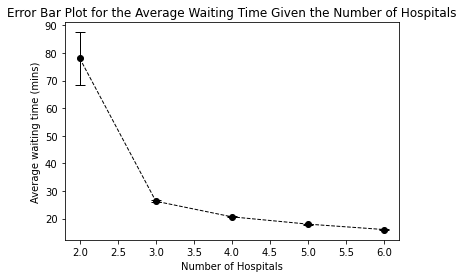

Expected Values: [78.061, 26.28, 20.622, 17.98, 16.015]
Confidence Intervals: [[68.584, 87.538], [25.856, 26.705], [20.405, 20.839], [17.809, 18.15], [15.882, 16.148]]


In [350]:
hosp_count_modeling(500, varying_stations)

In [337]:
def ambulance_count_modeling(n_trials, variables):

    # Acquire data
    hosp_count = variables # Number of Queue lines 
    tot_average_waiting_time = []
    tot_waiting_time_std = []
    tot_confidence_bars = []
    tot_confidence_intervals = []
    
    for var in variables:
    # We run simulations for every number of servers and queue lines 
        
        waiting_time = []

        for i in range(n_trials):
            sim = run_simulation(5000, random_ambulance = False, station_count = 3, 
                        num_ambulances = var, arrival_rate = 20, service_rate = 7,
                         end_sim = False, ambulance_stations = bad_ambulance_stations)

            ins = np.array(sim.times_in)

            outs = np.array(sim.times_out) 


            wait_time = np.mean(outs - ins) 
            waiting_time.append(wait_time)
                
        # Compute statistics 
        m = np.mean(waiting_time)
        std = np.std(waiting_time)
        conf = conf_int(waiting_time)
        conf_bar = conf_dist(waiting_time)
        
#         queue_count.append(queue)
        tot_average_waiting_time.append(np.round(m,3))
        tot_waiting_time_std.append(std)
        tot_confidence_bars.append(conf_bar)
        tot_confidence_intervals.append(conf)

    # Plot error bar, we use confidence interval to show the bar range 
    plt.errorbar(hosp_count, tot_average_waiting_time, tot_confidence_bars,
                color = 'black', marker = 'o', capsize = 5, linestyle = '--', linewidth = 1)
    plt.title("Error Bar Plot for the Average Waiting Time Given the Number of Ambulances per Station")
    plt.xlabel("Number of Ambulances per Station")
    plt.ylabel("Average waiting time (mins)")
    plt.show()
    
    print("Expected Values:", tot_average_waiting_time)
    print("Confidence Intervals:", tot_confidence_intervals)

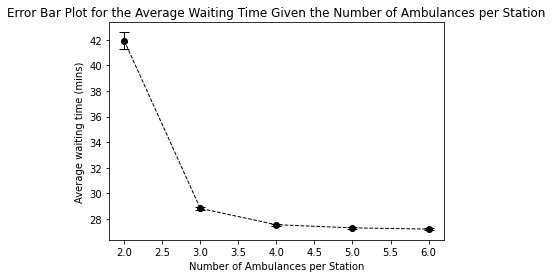

Expected Values: [41.932, 28.822, 27.549, 27.304, 27.206]
Confidence Intervals: [[41.283, 42.581], [28.721, 28.922], [27.48, 27.618], [27.24, 27.369], [27.143, 27.269]]


In [338]:
ambulance_count_modeling(500, varying_ambulance_counts)

### Comparing old vs new

In [356]:
def strat_map_sim(n_trials, stations, num_amb, random):
    
    average_waiting_times = [] 
    
    for i in range(n_trials):
        sim = run_simulation(1000, random_ambulance = random, station_count = 3, 
                    num_ambulances = num_amb, arrival_rate = 20, service_rate = 7,
                     end_sim = False, ambulance_stations = stations)

        ins = np.array(sim.times_in)

        outs = np.array(sim.times_out) 


        wait_time = np.mean(outs - ins)
        average_waiting_times.append(wait_time)

    return average_waiting_times 

good_mapping = strat_map_sim(1000, good_ambulance_stations, 3, False)
bad_mapping = strat_map_sim(1000, None, 2, True )



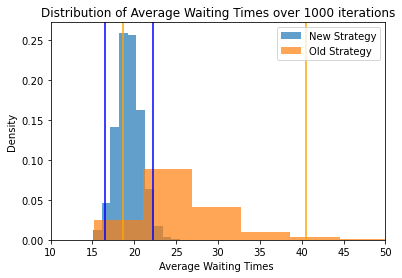

In [365]:
good_mapping_conf_int = conf_int(good_mapping)
bad_mapping_conf_int = conf_int(bad_mapping)

plt.hist(good_mapping, alpha = 0.7, label = 'New Strategy', density = True)
plt.hist(bad_mapping, alpha = 0.7, label = 'Old Strategy', density = True)

plt.axvline(good_mapping_conf_int[0], c = 'blue')
plt.axvline(good_mapping_conf_int[1], c = 'blue')
plt.axvline(bad_mapping_conf_int[0], c = 'orange')
plt.axvline(bad_mapping_conf_int[1], c = 'orange')

plt.xlim(10, 50)

plt.xlabel("Average Waiting Times ")
plt.ylabel("Density")
plt.title("Distribution of Average Waiting Times over 1000 iterations")
plt.legend(loc = "upper right")
plt.show() 

## Theoretical 

We will try predicting the average waiting time: 

$$\frac{\sum \text{weight of network}}{N_{nodes}} - \text{avg. service time} = \text{avg. waiting time}$$

In [463]:
ambulance_stations = ['psg', 'mnl', 'pnq']

def empiricalvstheoretical(n_trials, service_time):
    
    waiting_times = []
    
    for i in range(n_trials):
        sim = run_simulation(500, random_ambulance = False, station_count = 3, 
                            num_ambulances = 2, arrival_rate = 20, service_rate = 7,
                             end_sim = False, ambulance_stations = ambulance_stations)

        ins = np.array(sim.times_in)

        outs = np.array(sim.times_out) 

        waiting_time = outs - ins
        waiting_times.append(np.mean(waiting_time))
                             
    
    weight_sum = 0
    for i in dict(edgesdict).values():
        weight_sum += i['weight']
    
    theoretical = weight_sum/len(sim.g.nodes) - 7 
    empirical = np.mean(waiting_times)
                             
    plt.hist(waiting_times, alpha = 0.5)
    plt.title("Average Waiting Times (Theoretical vs Empirical)")
    plt.axvline(np.mean(waiting_times), c = 'r', label = 'empirical')
    plt.axvline(theoretical, c = 'orange', label = 'theoretical')
    plt.legend()
    plt.show()

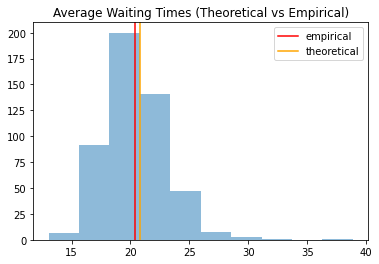

In [464]:
empiricalvstheoretical(500, 7)